# Data Continuation

## Modeling Preparation

We'll start off this process by doing much of the same
importing as from last time.

In [1]:
import gc
import numpy as np
import polars as pl
import pandas as pd
from pandarallel import pandarallel

pandarallel.initialize(
        progress_bar=True,
        nb_workers=10,
        verbose=2
    )

import seaborn as sns
import matplotlib.pyplot as plt

import cv2

#statsmodels
import statsmodels as sm
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# from statsmodels.regression.linear_model import OLS #?
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import \
            TfidfVectorizer, CountVectorizer

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

from joblib import parallel_backend, Parallel

from _code.card_selection import card_sampler, \
            plot_card_trends, card_imager, \
                synthesize_names

from _code.cleaner import preprocess

from _code.viz import showImagesHorizontally, word_plot

from _code import card_selection as FUNC_TESTING

from IPython.display import Image

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Additional Data Engineering

We have our information contexts that we can use a lot
more easily. We'll go ahead and do a couple more steps
to put our abilities into a format that we can use more
directly.

We'll start by bringing in the card data we made in the
last step.

In [2]:
cards = pd.read_parquet('./data/simplified_cards.parquet')

Because abilities are all stuck in the same place in
our oracle text but are all different abilities for the
context of each card. We need to split these out here.

In [3]:
processed_abilities = preprocess(cards['oracle_text'])
cards['abilities_list'] = [abilities.split('\n') for abilities in processed_abilities]

In [4]:
cards.head()[['name','oracle_text','abilities_list','median_foil','median_normal']]

,name,oracle_text,abilities_list,median_foil,median_normal
0,Fury Sliver,All Sliver creatures have double strike.,[sliver creature double strike],3.95,0.380
1,Kor Outfitter,"When CARDNAME enters the battlefield, you may ...",[cardname enters battlefield may attach target...,7.78,0.240
2,Siren Lookout,"Flying\nWhen CARDNAME enters the battlefield, ...","[fly , cardname enters battlefield explores ]",0.23,0.060
3,Web,Enchant creature (Target a creature as you cas...,"[enchant creature , enchant creature get +0/...",NaN,0.640
4,Venerable Knight,"When CARDNAME dies, put a +1/+1 counter on tar...",[cardname die put +1/+1 counter target knight ...,0.28,0.095


Something that might be important for our model is the
actual number of abilities that a card has. We'll go
ahead and account for that in our next step.

In [5]:
cards['n_abilities'] = cards['abilities_list'].map(len)

We'll go ahead and split card data here. First, we need
to make sure that we're able to keep set proportions
across both sets of data, since the set column is going
to account for a lot of different features to some
degree. For that, we can't have any unique or
single-card releases, like promos.

In [6]:
sets = cards['set'].value_counts()
promo_sets_list = sets[sets <= 1].index
unique_set_cards = cards[
        cards['set'].isin(promo_sets_list)
    ][['name','set']]
display(unique_set_cards.head(), len(unique_set_cards))

,name,set
1881,Rabbit Battery,pl23
3398,Helm of Kaldra,p5dn
5644,Underworld Dreams,p2hg
5989,Flooded Strand,pnat
6715,Wasteland,mpr


34

We have 34 cards that are individual printings in
unique sets. These are likely promotional cards from
before the promotional cards got all lumped together
into a promotional umbrella, so we'll drop those cards
from the data set. We'll go ahead and take any set with
less than 10 cards in it as well, since those will
mostly be promotional sets and we're really only
targeting regular releases.

In [7]:
promo_sets_list = sets[sets <= 10].index
unique_set_cards = cards[
        cards['set'].isin(promo_sets_list)
    ][['name','set']]
display(unique_set_cards.head())

,name,set
57,Elvish Aberration,pal03
75,"Kamahl, Pit Fighter",p15a
113,Scourge of Fleets,pjou
165,Plains,prwk
202,Grim Lavamancer,g06


In [8]:
reduced_cards = cards[~cards['set'].isin(promo_sets_list)]
display(reduced_cards.head(),reduced_cards.shape)

,id,oracle_id,tcgplayer_id,name,released_at,image_uris,mana_cost,cmc,type_line,oracle_text,...,promo_types,loyalty,produced_mana,variation_of,prices_normal,prices_foil,median_normal,median_foil,abilities_list,n_abilities
0,0000579f-7b35-4ed3-b44c-db2a538066fe,44623693-51d6-49ad-8cd7-140505caf02f,14240.0,Fury Sliver,2006-10-06,{'art_crop': 'https://cards.scryfall.io/art_cr...,{5}{R},6.0,Creature — Sliver,All Sliver creatures have double strike.,...,None,None,None,None,"{'2023-01-27': 0.37, '2023-01-28': 0.37, '2023...","{'2023-01-27': 3.95, '2023-01-28': 3.95, '2023...",0.380,3.95,[sliver creature double strike],1
1,00006596-1166-4a79-8443-ca9f82e6db4e,8ae3562f-28b7-4462-96ed-be0cf7052ccc,33347.0,Kor Outfitter,2009-10-02,{'art_crop': 'https://cards.scryfall.io/art_cr...,{W}{W},2.0,Creature — Kor Soldier,"When CARDNAME enters the battlefield, you may ...",...,None,None,None,None,"{'2023-01-27': 0.11, '2023-01-28': 0.11, '2023...","{'2023-01-27': 7.5, '2023-01-28': 7.5, '2023-0...",0.240,7.78,[cardname enters battlefield may attach target...,1
2,0000cd57-91fe-411f-b798-646e965eec37,9f0d82ae-38bf-45d8-8cda-982b6ead1d72,145764.0,Siren Lookout,2017-09-29,{'art_crop': 'https://cards.scryfall.io/art_cr...,{2}{U},3.0,Creature — Siren Pirate,"Flying\nWhen CARDNAME enters the battlefield, ...",...,None,None,None,None,"{'2023-01-27': 0.04, '2023-01-28': 0.04, '2023...","{'2023-01-27': 0.26, '2023-01-28': 0.26, '2023...",0.060,0.23,"[fly , cardname enters battlefield explores ]",2
3,00012bd8-ed68-4978-a22d-f450c8a6e048,5aa12aff-db3c-4be5-822b-3afdf536b33e,1623.0,Web,1994-04-01,{'art_crop': 'https://cards.scryfall.io/art_cr...,{G},1.0,Enchantment — Aura,Enchant creature (Target a creature as you cas...,...,None,None,None,None,"{'2023-01-27': 0.65, '2023-01-28': 0.65, '2023...",None,0.640,NaN,"[enchant creature , enchant creature get +0/...",2
4,0001f1ef-b957-4a55-b47f-14839cdbab6f,ef027846-be81-4959-a6b5-56bd01b1e68a,198861.0,Venerable Knight,2019-10-04,{'art_crop': 'https://cards.scryfall.io/art_cr...,{W},1.0,Creature — Human Knight,"When CARDNAME dies, put a +1/+1 counter on tar...",...,None,None,None,None,"{'2023-01-27': 0.09, '2023-01-28': 0.09, '2023...","{'2023-01-27': 0.29, '2023-01-28': 0.29, '2023...",0.095,0.28,[cardname die put +1/+1 counter target knight ...,1


(62370, 40)

Clocking in at 62,370 cards, we're ready to do the
actual data split.

In [9]:
X = reduced_cards.drop(columns=['prices_normal','prices_foil'])
y = reduced_cards['set']
train, test, train_strat, test_strat = \
    train_test_split(
        X,y,stratify=y,
        random_state=13,
        test_size=0.2
    )


In [10]:
# resetting all of the indices so they can be
# translated between polars and pandas

for item in (train,test):
    item.reset_index(drop=True,inplace=True)

...and just to verify that they're roughly the same
distribution:

In [11]:
train['set'].value_counts(normalize=True)[:5],\
    test['set'].value_counts(normalize=True)[:5]

(set
 mb1      0.027116
 plist    0.016935
 clb      0.014430
 sld      0.013749
 j22      0.013388
 Name: proportion, dtype: float64,
 set
 mb1      0.027096
 plist    0.016995
 clb      0.014430
 sld      0.013789
 j22      0.013388
 Name: proportion, dtype: float64)

Great, we have a good level of stratification across
our sets. We can move on to the next step of the
process, which will involve tokenizing the different
abilities and then vectorizing the data in a way that
will be useful for us. We can create our vectorizer,
double check our values, and prep our data for being
vectorized.

## Vectorizing the Abilities

Bringing our oracle texts into a format that the
modeling processes can use is one of the most important
steps here. We'll want to make sure we limit the output
to make sure we can actually use the dataframe within
memory limits.

In [12]:

token_pattern = r"([a-zA-Z]+(?:’[a-z]+)?|[+-]?\d\/[+-]?\d|\{\d\d?\}|\{.\s?.?\}|\n)|\(.+?\)"
# tokenizer = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?|[+-]?\d\/[+-]?\d|\{\d\d?\}|\{.\s?.?\}|\n)|\(.+?\)")
cvec = CountVectorizer(
        token_pattern=token_pattern,
        # min_df=0.0005, # <= this will mean that the
                    # minimum number of cards that it
                    # takes for an ability to show up
                    # on this list will be 46 after the
                    # explode is run, since it will be
                    # 83,000 entries long. We'll just
                    # limit our overall features since
                    # this is such a small percentage. 
        max_df=0.4,
        ngram_range=(1,5),
        max_features=1500
    )

Our abilities are currently in the form of lists of
strings, so we'll need to explode this out so that we
can vectorize properly. We don't want to just bring
these lists back into strings because these individual
strings are separate abilities.

Instead, we'll explode these arrays into different
entries and then vectorize those into abilities, and as
a last step in this process, we'll bring them all back
together with a grouping process.

In [13]:
train[['name','abilities_list']].head()

,name,abilities_list
0,Stolen Identity,"[create token copy target artifact creature , ..."
1,Ageless Entity,[whenever gain life put many +1/+1 counter car...
2,Izzet Locket,"[{t} add {u} {r} , u r u r u r u r {t} sacrif..."
3,Inspired Charge,[creature control get +2/+1 end turn]
4,"Oros, the Avenger","[fly , whenever cardname deal combat damage p..."


In [14]:
explode_train = train.explode('abilities_list')
explode_train.head(10)

,id,oracle_id,tcgplayer_id,name,released_at,image_uris,mana_cost,cmc,type_line,oracle_text,...,edhrec_rank,related_uris,promo_types,loyalty,produced_mana,variation_of,median_normal,median_foil,abilities_list,n_abilities
0,2831fe77-ea98-4334-a78e-01580fb002c0,30b533a3-afc3-4500-a8f0-54e84301988f,269779.0,Stolen Identity,2022-04-29,{'art_crop': 'https://cards.scryfall.io/art_cr...,{4}{U}{U},6.0,Sorcery,Create a token that's a copy of target artifac...,...,2243.0,{'edhrec': 'https://edhrec.com/route/?cc=Stole...,None,None,None,None,0.21,NaN,create token copy target artifact creature,2
0,2831fe77-ea98-4334-a78e-01580fb002c0,30b533a3-afc3-4500-a8f0-54e84301988f,269779.0,Stolen Identity,2022-04-29,{'art_crop': 'https://cards.scryfall.io/art_cr...,{4}{U}{U},6.0,Sorcery,Create a token that's a copy of target artifac...,...,2243.0,{'edhrec': 'https://edhrec.com/route/?cc=Stole...,None,None,None,None,0.21,NaN,cipher,2
1,f2d9b77b-d775-4546-91c8-df438a1d8dbe,2a93236d-f182-4826-8112-4048bb3cbaf9,11606.0,Ageless Entity,2004-02-06,{'art_crop': 'https://cards.scryfall.io/art_cr...,{3}{G}{G},5.0,Creature — Elemental,"Whenever you gain life, put that many +1/+1 co...",...,8179.0,{'edhrec': 'https://edhrec.com/route/?cc=Agele...,None,None,None,None,0.26,1.79,whenever gain life put many +1/+1 counter card...,1
2,a32ecc71-b924-4414-94ee-c6cb0ba752e5,7ee07546-2c2e-4679-b671-7ea509b1d3ea,196588.0,Izzet Locket,2019-08-23,{'art_crop': 'https://cards.scryfall.io/art_cr...,{3},3.0,Artifact,"{T}: Add {U} or {R}.\n{U/R}{U/R}{U/R}{U/R}, {T...",...,3842.0,{'edhrec': 'https://edhrec.com/route/?cc=Izzet...,None,None,"[R, U]",None,0.11,NaN,{t} add {u} {r},2
2,a32ecc71-b924-4414-94ee-c6cb0ba752e5,7ee07546-2c2e-4679-b671-7ea509b1d3ea,196588.0,Izzet Locket,2019-08-23,{'art_crop': 'https://cards.scryfall.io/art_cr...,{3},3.0,Artifact,"{T}: Add {U} or {R}.\n{U/R}{U/R}{U/R}{U/R}, {T...",...,3842.0,{'edhrec': 'https://edhrec.com/route/?cc=Izzet...,None,None,"[R, U]",None,0.11,NaN,u r u r u r u r {t} sacrifice cardname draw t...,2
3,98151986-90de-4f76-9abd-507039e7c9ad,d465a3d6-5830-456c-8e7a-908b464db846,35656.0,Inspired Charge,2010-07-16,{'art_crop': 'https://cards.scryfall.io/art_cr...,{2}{W}{W},4.0,Instant,Creatures you control get +2/+1 until end of t...,...,14291.0,{'edhrec': 'https://edhrec.com/route/?cc=Inspi...,None,None,None,None,0.05,NaN,creature control get +2/+1 end turn,1
4,c2790685-f6ae-4106-ae4d-fe97954bcb82,454b898f-b134-4d63-ae7b-1e736964cd48,14772.0,"Oros, the Avenger",2007-02-02,{'art_crop': 'https://cards.scryfall.io/art_cr...,{3}{R}{W}{B},6.0,Legendary Creature — Dragon,Flying\nWhenever CARDNAME deals combat damage ...,...,11479.0,{'edhrec': 'https://edhrec.com/route/?cc=Oros%...,None,None,None,None,0.55,9.50,fly,2
4,c2790685-f6ae-4106-ae4d-fe97954bcb82,454b898f-b134-4d63-ae7b-1e736964cd48,14772.0,"Oros, the Avenger",2007-02-02,{'art_crop': 'https://cards.scryfall.io/art_cr...,{3}{R}{W}{B},6.0,Legendary Creature — Dragon,Flying\nWhenever CARDNAME deals combat damage ...,...,11479.0,{'edhrec': 'https://edhrec.com/route/?cc=Oros%...,None,None,None,None,0.55,9.50,whenever cardname deal combat damage player m...,2
5,fa4336df-63ea-4e98-9cfb-a42582acbca2,0f052d9f-5a40-4eb9-9d8a-e01dec1db191,203305.0,Serra Disciple,2019-11-07,{'art_crop': 'https://cards.scryfall.io/art_cr...,{1}{W},2.0,Creature — Bird Cleric,"Flying, first strike\nWhenever you cast a hist...",...,16902.0,{'edhrec': 'https://edhrec.com/route/?cc=Serra...,None,None,None,None,0.11,NaN,fly first strike,2
5,fa4336df-63ea-4e98-9cfb-a42582acbca2,0f052d9f-5a40-4eb9-9d8a-e01dec1db191,203305.0,Serra Disciple,2019-11-07,{'art_crop': 'https://cards.scryfall.io/art_cr...,{1}{W},2.0,Creature — Bird Cleric,"Flying, first strike\nWhenever you cast a hist...",...,16902.0,{'edhrec': 'https://edhrec.com/route/?cc=Serra...,None,None,None,None,0.11,NaN,whenever cast historic spell cardname get +1/...,2


In [15]:
explode_vec = cvec.fit_transform(
        explode_train['abilities_list']
    )
explode_vec = pd.DataFrame.sparse.from_spmatrix(
    explode_vec
)
explode_vec.columns = sorted(cvec.vocabulary_)
explode_vec['uuid'] = explode_train['id'].values
explode_vec.head()

,+1/+0,+1/+0 end,+1/+0 end turn,+1/+1,+1/+1 counter,+1/+1 counter cardname,+1/+1 counter creature,+1/+1 counter creature control,+1/+1 counter target,+1/+1 counter target creature,...,{u} {t},{u} {u},{w},{w} cardname,{w} {b},{w} {t},{w} {u},{w} {w},{x},uuid
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2831fe77-ea98-4334-a78e-01580fb002c0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2831fe77-ea98-4334-a78e-01580fb002c0
2,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f2d9b77b-d775-4546-91c8-df438a1d8dbe
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,a32ecc71-b924-4414-94ee-c6cb0ba752e5
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,a32ecc71-b924-4414-94ee-c6cb0ba752e5


In [16]:
explode_vec['uuid'].nunique(),explode_vec.shape[0]

(49896, 88164)

In [17]:
# Xplode_vec['uuid'].nunique(),Xplode_vec.shape[0]

To process the grouping in a much more timely manner,
we'll convert the exploded dataframe into a polars data
frame for our sum aggregation. Afterwards, we'll go
back to using pandas for familiarity, but it would be
interesting to see how the rest of this project would
work with polars as the primary data manipulation
package.

In [18]:
pl_vec = pl.from_pandas(explode_vec.astype(np.int32,errors='ignore'))
agged_vec = pl_vec.groupby('uuid').sum().to_pandas()

In [19]:
# pl_vec = pl.from_pandas(Xplode_vec.astype(np.int32,errors='ignore'))
# agged_vec = pl_vec.groupby('uuid').sum().to_pandas()

In [20]:
agged_vec.shape

(49896, 1501)

## Expanding Card Types

There are a ton of card types in Magic. We can split
these out with a Count Vectorizer. For now, we'll just
focus on the card types and not subtypes, since the
card type effects how the card is actually played and
the subtype is much less important, generally speaking.

In [21]:
card_type_cvec = CountVectorizer()

type_frame = pl.from_pandas(train['type_line']).apply(lambda x: x.split('—')[0])
type_df = pd.DataFrame.sparse.from_spmatrix(
    card_type_cvec.fit_transform(type_frame)
)
type_df.columns = sorted(card_type_cvec.vocabulary_)
type_df['uuid'] = train['id']
display(type_df.head(),type_df.shape)

,artifact,basic,conspiracy,creature,enchantment,instant,land,legendary,planeswalker,snow,sorcery,stickers,tribal,world,uuid
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2831fe77-ea98-4334-a78e-01580fb002c0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,f2d9b77b-d775-4546-91c8-df438a1d8dbe
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,a32ecc71-b924-4414-94ee-c6cb0ba752e5
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,98151986-90de-4f76-9abd-507039e7c9ad
4,0,0,0,1,0,0,0,1,0,0,0,0,0,0,c2790685-f6ae-4106-ae4d-fe97954bcb82


(49896, 15)

It looks like there are still a couple of things we'll
want to get rid of in the data set. Sticker and
Conspiracy cards are, generally speaking, not playable
or worth anything. We want to be focused on pretty much
anything else. We'll keep this is mind when we merge
everything back together.

## Color Identity

Another item that will be of use is the Color Identity
feature. Because Commander plays such a large role in
determining card pricing, color identity may have a
genuine impact on a card's value. Let's take a look at
how the color identity is stored in our data set.

In [22]:
train[['color_identity']].head()

,color_identity
0,[U]
1,[G]
2,"[R, U]"
3,[W]
4,"[B, R, W]"


This is another list of strings, but this should be
pretty easy to pull out. Since all of the values are
single letters, we can map a `' '.join()` across the
values.

In [23]:
train['str_color_identity'] = \
    train['color_identity'].map(lambda x: ' '.join(x))

In [24]:
train[['str_color_identity']].head()

,str_color_identity
0,U
1,G
2,R U
3,W
4,B R W


In [25]:
color_match = CountVectorizer(
    token_pattern=r"[wubrg]"
)
color_id_df = pd.DataFrame.sparse.from_spmatrix(
    color_match.fit_transform(train['str_color_identity'])
)
color_id_df.columns = sorted(color_match.vocabulary_)
color_id_df['c'] = color_id_df.T.apply(lambda x: 1 if sum(x)==0 else 0)
color_id_df['uuid'] = train['id']

In [26]:
color_id_df

,b,g,r,u,w,c,uuid
0,0,0,0,1,0,0,2831fe77-ea98-4334-a78e-01580fb002c0
1,0,1,0,0,0,0,f2d9b77b-d775-4546-91c8-df438a1d8dbe
2,0,0,1,1,0,0,a32ecc71-b924-4414-94ee-c6cb0ba752e5
3,0,0,0,0,1,0,98151986-90de-4f76-9abd-507039e7c9ad
4,1,0,1,0,1,0,c2790685-f6ae-4106-ae4d-fe97954bcb82
...,...,...,...,...,...,...,...
49891,0,0,0,1,0,0,59d38ef7-5017-4ea3-b97f-a8fe12d03e98
49892,1,0,0,0,0,0,4b3da66a-ac81-4300-80a1-f70cdb104a90
49893,1,0,0,0,0,0,39e11c98-e19f-4b38-acda-504d291c7f42
49894,0,0,0,0,1,0,0710e943-8882-4a31-973b-1bb07d545af8


Great! We have all of our colors separated out, our
abilities are vectorized, and our card types are in
their own categories. As a last sanity check before we
go into the final preparation, we'll check the shapes
of all of our data frames.

In [27]:
_tmp_items = dict(zip(
    [
        'Colors:     ',
        'Types:      ',
        'Abilities:  ',
        'Everything: '
    ],
    [
        color_id_df.shape[0],
        type_df.shape[0],
        agged_vec.shape[0],
        train.shape[0]
    ]
    ))
for k,v in _tmp_items.items():
    print(k,v)

Colors:      49896
Types:       49896
Abilities:   49896
Everything:  49896


In [28]:
train[['median_normal','median_foil']].median()

median_normal    0.22
median_foil      0.90
dtype: float64

## More Dataframe Reduction

We'll reduce our column count just a little bit before
prepping our final data for processing. 

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49896 entries, 0 to 49895
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  49896 non-null  object        
 1   oracle_id           49896 non-null  object        
 2   tcgplayer_id        49499 non-null  float64       
 3   name                49896 non-null  object        
 4   released_at         49896 non-null  datetime64[ns]
 5   image_uris          49896 non-null  object        
 6   mana_cost           49896 non-null  object        
 7   cmc                 49896 non-null  float64       
 8   type_line           49896 non-null  object        
 9   oracle_text         49896 non-null  object        
 10  power               24195 non-null  object        
 11  toughness           24195 non-null  object        
 12  colors              49896 non-null  object        
 13  color_identity      49896 non-null  object    

In [30]:
used_columns = [
    'id',
    # 'oracle_id',
    # 'tcgplayer_id',
    # 'name',
    'released_at',  # Our data may care about the age
                    # of a card in calculations, so we
                    # want to keep it here and account
                    # for a new/existing card later. 
    # 'image_uris',
    'mana_cost',    # may need additional processing.
    'cmc',
    # 'type_line',    # this is already captured as types
    # 'oracle_text',  # this has already been extracted
                    # as abilities
    'power',
    'toughness',
    # 'colors',
    # 'color_identity', # already vectorized
    # 'keywords',     # <= part of the abilities we
                    # extracted, may be useful to look
                    # at at another point 
    # 'legalities',   # <= since we're only looking at
                    # prices for new cards in this
                    # exploration, we can ignore the
                    # legalities of cards for now. This
                    # may be a good thing to look at in
                    # next steps. 
    # 'reserved',
    # 'foil',         # Both foil and nonfoil are
    # 'nonfoil',      # captured in price data
    'promo',
    'reprint',
    # 'variation',
    # 'set_id',       # This section may be useful for
    # 'set',          # later iterations. Ignoring for
    # 'set_type',     # now.
    'rarity',
    'full_art',
    'textless',
    # 'edhrec_rank',  # This may actually be a reall
                    # useful metric to look at, but it
                    # will have to come into play at a
                    # later time. 
    # 'related_uris',
    # 'promo_types',
    'loyalty',
    # 'produced_mana',  # Unsure of the effectiveness
                        # of this, but it's worth
                        # looking into later
    # 'variation_of',
    # 'abilities_list',   # This has already been
                        # captured by our explode.
    'n_abilities',
    'median_normal',    # Need to keep targets
    'median_foil'
]

In [31]:
train_reduced = train[used_columns].copy()

In [32]:
train_reduced.rename({
    'power':'card_power',
    'toughness':'card_toughness',
    'loyalty':'card_loyalty'
},axis=1,inplace=True)

In [33]:
train_reduced.shape

(49896, 15)

In [34]:
train_combined = train_reduced.merge(
    agged_vec,
    left_on='id',
    right_on='uuid',
    how='left'
).merge(
    type_df,
    on='uuid',
    how='left',
    suffixes=(None,'_card_type')
).merge(
    color_id_df,
    on='uuid',
    how='left',
    suffixes=(None,'_color_id')
).drop(columns=['uuid'])

In [35]:
train_combined = train_combined[
    (train_combined[ 'stickers' ] == 0) &
    (train_combined['conspiracy'] == 0)
].drop(columns=['stickers','conspiracy']).copy()

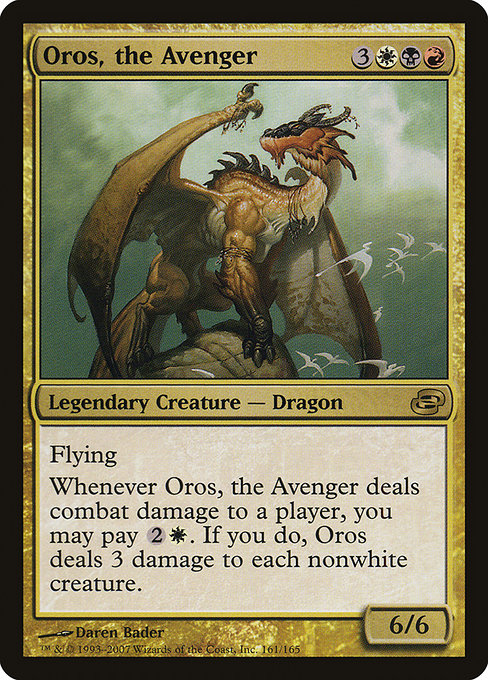

In [36]:
Image(cards[cards['id'] == 'c2790685-f6ae-4106-ae4d-fe97954bcb82'].iloc[0]['image_uris']['normal'].split('?')[0])

In [37]:
train_combined.head()

,id,released_at,mana_cost,cmc,card_power,card_toughness,promo,reprint,rarity,full_art,...,snow,sorcery_card_type,tribal,world,b,g,r_color_id,u_color_id,w_color_id,c
0,2831fe77-ea98-4334-a78e-01580fb002c0,2022-04-29,{4}{U}{U},6.0,None,None,False,True,rare,False,...,0,1,0,0,0,0,0,1,0,0
1,f2d9b77b-d775-4546-91c8-df438a1d8dbe,2004-02-06,{3}{G}{G},5.0,4,4,False,False,rare,False,...,0,0,0,0,0,1,0,0,0,0
2,a32ecc71-b924-4414-94ee-c6cb0ba752e5,2019-08-23,{3},3.0,None,None,False,True,common,False,...,0,0,0,0,0,0,1,1,0,0
3,98151986-90de-4f76-9abd-507039e7c9ad,2010-07-16,{2}{W}{W},4.0,None,None,False,False,common,False,...,0,0,0,0,0,0,0,0,1,0
4,c2790685-f6ae-4106-ae4d-fe97954bcb82,2007-02-02,{3}{R}{W}{B},6.0,6,6,False,False,rare,False,...,0,0,0,0,1,0,1,0,1,0


In [38]:
train_combined.shape

(49835, 1533)

Limit the training data down to the cards that were
kept from earlier

In [39]:
_n_sample = train_combined[
    ~train_combined['median_normal'].isnull()
    ]['median_normal']
_f_sample = train_combined[
    ~train_combined['median_foil'].isnull()
    ]['median_foil']
(_n_sample.shape[0],train_combined.shape[0]),\
(_f_sample.shape[0],train_combined.shape[0])

((45326, 49835), (31235, 49835))

In [40]:
train_combined[['median_normal','median_foil']]

,median_normal,median_foil
0,0.21,NaN
1,0.26,1.79
2,0.11,NaN
3,0.05,NaN
4,0.55,9.50
...,...,...
49891,0.08,0.25
49892,0.12,5.04
49893,0.04,0.69
49894,0.11,NaN


## DUMMY MODEL / TEST

In [41]:
_meds = train_combined[['median_normal','median_foil']].median().to_list()
n_med_guess = [_meds[0] for item in _n_sample.values]
f_med_guess = [_meds[1] for item in _f_sample.values]

In [42]:
mean_squared_error(_n_sample,n_med_guess,squared=False),\
    mean_squared_error(_f_sample,f_med_guess,squared=False)

(91.61351060604377, 47.27888337720371)

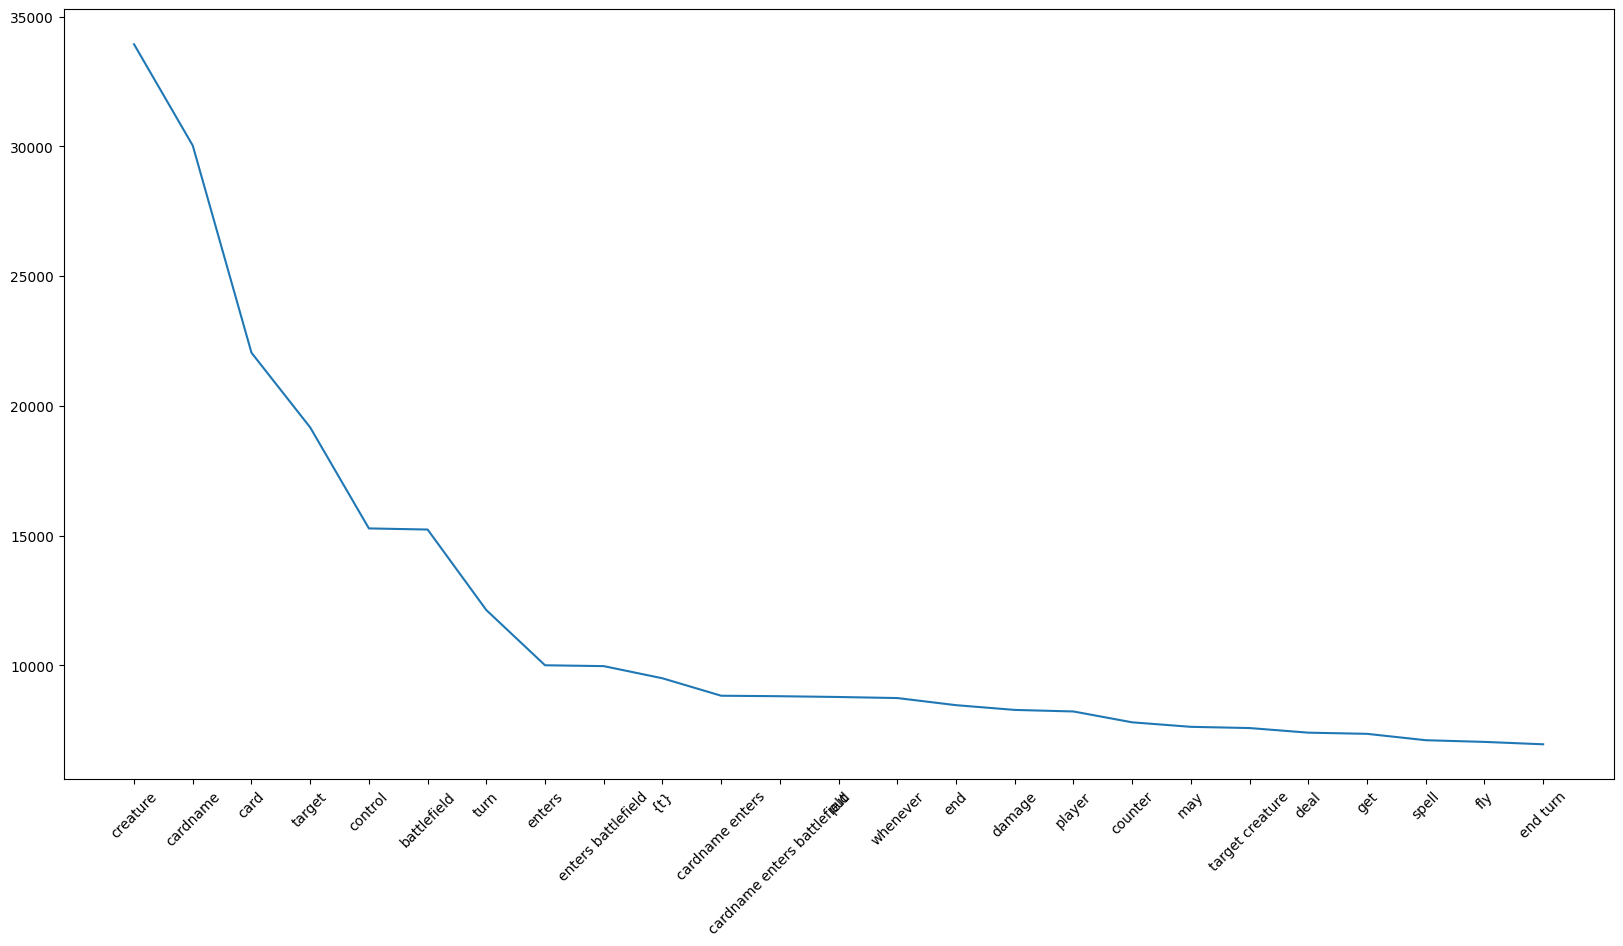

In [43]:
_docs = []
for ability in train['abilities_list']:
    _docs.extend(ability)

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(explode_vec.drop(columns=['uuid']).sum().sort_values(ascending=False)[:25])
plt.xticks(rotation=45);

In [44]:
train_combined[['card_power','card_toughness','card_loyalty']]

,card_power,card_toughness,card_loyalty
0,None,None,None
1,4,4,None
2,None,None,None
3,None,None,None
4,6,6,None
...,...,...,...
49891,3,3,None
49892,2,2,None
49893,2,2,None
49894,None,None,None


In [45]:
train_ohe = pd.get_dummies(train_combined,columns=['rarity','card_power','card_toughness','card_loyalty'])

In [46]:
train_ohe.select_dtypes('object')

,id,mana_cost
0,2831fe77-ea98-4334-a78e-01580fb002c0,{4}{U}{U}
1,f2d9b77b-d775-4546-91c8-df438a1d8dbe,{3}{G}{G}
2,a32ecc71-b924-4414-94ee-c6cb0ba752e5,{3}
3,98151986-90de-4f76-9abd-507039e7c9ad,{2}{W}{W}
4,c2790685-f6ae-4106-ae4d-fe97954bcb82,{3}{R}{W}{B}
...,...,...
49891,59d38ef7-5017-4ea3-b97f-a8fe12d03e98,{3}{U}{U}
49892,4b3da66a-ac81-4300-80a1-f70cdb104a90,{B}{B}
49893,39e11c98-e19f-4b38-acda-504d291c7f42,{1}{B}
49894,0710e943-8882-4a31-973b-1bb07d545af8,{W}


### Convert Dates to Date Deltas

In [47]:
train_ohe['released_at']

0       2022-04-29
1       2004-02-06
2       2019-08-23
3       2010-07-16
4       2007-02-02
           ...    
49891   2020-07-03
49892   2001-04-11
49893   2005-07-29
49894   2016-11-11
49895   2015-07-17
Name: released_at, Length: 49835, dtype: datetime64[ns]

In [48]:
_now = pd.Timestamp.today().floor('D')
train_ohe['card_age'] = train_ohe['released_at'].apply(lambda x: (_now - x).days)
train_ohe.drop(columns=['released_at'],inplace=True)

# ===============
# SECTION SPLIT
# ===============

In [49]:
eeeeeeeeeeeeeee

NameError: name 'eeeeeeeeeeeeeee' is not defined

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
train_normal = train_ohe.dropna(
    subset=['median_normal']
    ).drop(columns=['median_foil','mana_cost']
    ).reset_index(drop=True)

train_foil = train_ohe.dropna(subset=['median_foil']
    ).drop(columns=['median_normal','mana_cost']
    ).reset_index(drop=True)

train_normal.shape[0], train_foil.shape[0]

In [ ]:
ElasticNetCV?

Init signature:
ElasticNetCV(
    *,
    l1_ratio=0.5,
    eps=0.001,
    n_alphas=100,
    alphas=None,
    fit_intercept=True,
    precompute='auto',
    max_iter=1000,
    tol=0.0001,
    cv=None,
    copy_X=True,
    verbose=0,
    n_jobs=None,
    positive=False,
    random_state=None,
    selection='cyclic',
)
Docstring:     
Elastic Net model with iterative fitting along a regularization path.

See glossary entry for :term:`cross-validation estimator`.

Read more in the :ref:`User Guide <elastic_net>`.

Parameters
----------
l1_ratio : float or list of float, default=0.5
    Float between 0 and 1 passed to ElasticNet (scaling between
    l1 and l2 penalties). For ``l1_ratio = 0``
    the penalty is an L2 penalty. For ``l1_ratio = 1`` it is an L1 penalty.
    For ``0 < l1_ratio < 1``, the penalty is a combination of L1 and L2
    This parameter can be a list, in which case the different
    values are tested by cross-validation and the one giving the best
    prediction score is 

In [ ]:
from sklearn.linear_model import ElasticNetCV
_test_net = ElasticNetCV(n_jobs=-3,verbose=3,random_state=13,positive=True,l1_ratio=0.8)

In [ ]:
_test_net.fit(train_normal.drop(columns=['id','median_normal']),train_normal['median_normal'])

/home/jd/anaconda3/envs/spells/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
[Parallel(n_jobs=-3)]: Using backend ThreadingBackend with 22 concurrent workers.


(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       0.00000000e+00, 0.00000000e+00, 5.65352484e-05]), -5.960464477539063e-08, 33860.67515542418, 2)
(array([0.       , 0.       , 0.       , ..., 0.       , 0.       ,
       0.0001958]), 0.0, 33860.67515542418, 2)
(array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.00032568]), 5.960464477539063e-08, 33860.67515542418, 2)
(array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.00044682]), 5.960464477539063e-08, 33860.67515542418, 2)
(array([0., 0., 0., ..., 0., 0., 0.]), 0.0, 33052.46115007221, 1)
(array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.00013841]), 5.960464477539063e-08, 33052.46115007221, 2)
(array([0.       , 0.       , 0.       , ..., 0.       , 0.       ,
       0.0005598]), 0.0, 33860.67515542418, 2)
(array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.00026834]), 5.960464477539063e-08, 33052.

[Parallel(n_jobs=-3)]: Done   2 out of   5 | elapsed:    5.4s remaining:    8.1s
[Parallel(n_jobs=-3)]: Done   5 out of   5 | elapsed:    5.4s finished


ElasticNetCV(l1_ratio=0.8, n_jobs=-3, positive=True, random_state=13, verbose=3)

In [ ]:
pred_prices = _test_net.predict(train_normal.drop(columns=['id','median_normal']))

/home/jd/anaconda3/envs/spells/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [ ]:
guess_frame = pd.DataFrame(zip(pred_prices,train_normal['median_normal']),columns=['predicted','actual'])

In [ ]:
guess_frame['id'] = train_normal['id']
guess_frame['image_uris'] = guess_frame.merge(
    train[['id','image_uris']],
    how='left'
)['image_uris']
guess_frame['difference'] = guess_frame['predicted'] - guess_frame['actual']
guess_frame['abs_diff'] = abs(guess_frame['difference'])

_p_guess_head = guess_frame.sort_values('predicted',ascending=False).head(10)
_a_guess_head = guess_frame.sort_values('actual',ascending=False).head(10)
_over_diff_guess_head = guess_frame.sort_values('difference',ascending=False).head(10)
_under_diff_guess_head = guess_frame.sort_values('difference',ascending=True).head(10)
_closest_guess_head = guess_frame.sort_values('abs_diff',ascending=True).head(10)
_furthest_guess_head = guess_frame.sort_values('abs_diff',ascending=False).head(10)


    Actual Price: 11999.99
    Predicted Price: 20.899085541256145


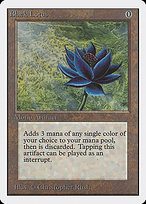


    Actual Price: 8500.0
    Predicted Price: 20.899085541256145


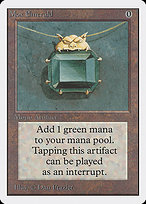


    Actual Price: 3599.99
    Predicted Price: 21.142212350985236


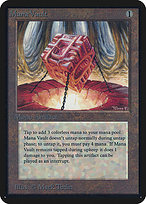


    Actual Price: 3195.89
    Predicted Price: 20.899085541256145


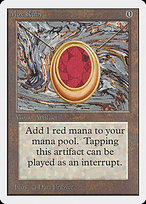


    Actual Price: 2799.99
    Predicted Price: 21.01858854942807


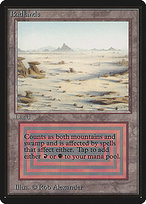


    Actual Price: 2601.98
    Predicted Price: 20.899085541256145


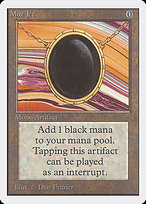


    Actual Price: 2500.0
    Predicted Price: 20.88054197102257


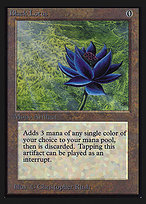


    Actual Price: 2500.0
    Predicted Price: 20.524093343199404


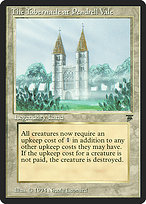


    Actual Price: 2500.0
    Predicted Price: 20.899085541256145


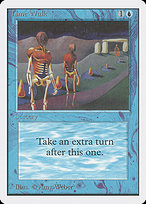


    Actual Price: 2400.0
    Predicted Price: -1.093588755763765


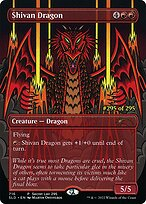

In [ ]:
for i, card in _a_guess_head.iterrows():
    print(f"""
    Actual Price: {card['actual']}
    Predicted Price: {card['predicted']}""")
    display(Image(card['image_uris']['small'].split('?')[0]))

In [ ]:
guess_frame['predicted'].max()

21.142212350985236


    Actual Price: 43.16
    Predicted Price: 21.14218936307147


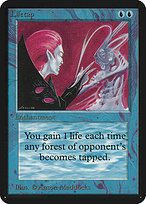


    Actual Price: 276.99
    Predicted Price: 21.14218936307147


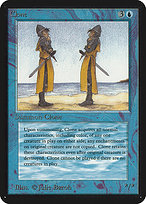


    Actual Price: 57.99
    Predicted Price: 21.14218936307147


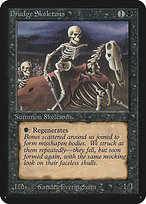


    Actual Price: 519.98
    Predicted Price: 21.14218936307147


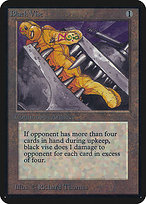


    Actual Price: 46.61
    Predicted Price: 21.14218936307147


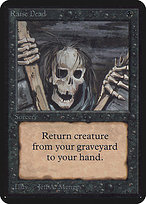


    Actual Price: 84.05
    Predicted Price: 21.14218936307147


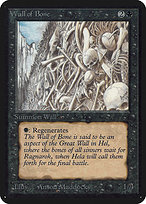


    Actual Price: 39.7
    Predicted Price: 21.14218936307147


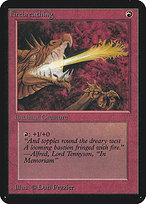


    Actual Price: 498.0
    Predicted Price: 21.14218936307147


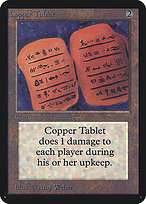


    Actual Price: 70.77000000000001
    Predicted Price: 21.14218936307147


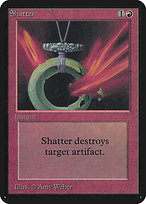


    Actual Price: 25.99
    Predicted Price: 21.14218936307147


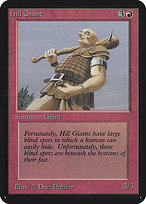

In [ ]:
for i, card in _p_guess_head.iterrows():
    print(f"""
    Actual Price: {card['actual']}
    Predicted Price: {card['predicted']}""")
    display(Image(card['image_uris']['small'].split('?')[0]))

In [ ]:
from IPython.display import Markdown

In [ ]:
rng = [1,5,10,100]
_header = f"""
| diff_amnt | within range | remaining | % |
|---|---|---|---|"""
_table = [_header]
gf_shape = guess_frame.shape[0]
for _rng in rng:
    cf_shape = guess_frame[guess_frame['abs_diff']<_rng].shape[0]
    _table.append(f"""| ${_rng:,.2f} |  {cf_shape} | {gf_shape-cf_shape} | {(cf_shape/gf_shape)*100:,.1f}% |""")

In [ ]:
Markdown('\n'.join(_table))


| diff_amnt | within range | remaining | % |
|---|---|---|---|
| $1.00 |  8800 | 36526 | 19.4% |
| $5.00 |  24273 | 21053 | 53.6% |
| $10.00 |  32365 | 12961 | 71.4% |
| $100.00 |  44959 | 367 | 99.2% |


    Actual Price: 11999.99
    Predicted Price: 20.89906292942113


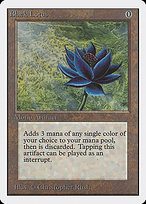


    Actual Price: 8500.0
    Predicted Price: 20.89906292942113


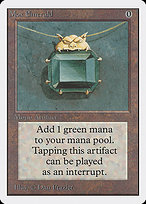


    Actual Price: 3599.99
    Predicted Price: 21.14218936307147


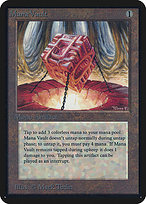


    Actual Price: 3195.89
    Predicted Price: 20.89906292942113


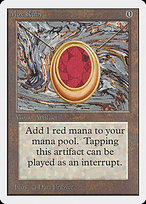


    Actual Price: 2799.99
    Predicted Price: 21.018565752740788


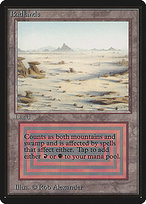


    Actual Price: 2601.98
    Predicted Price: 20.89906292942113


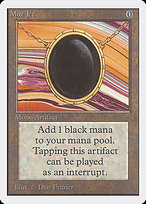


    Actual Price: 2500.0
    Predicted Price: 20.524071311418062


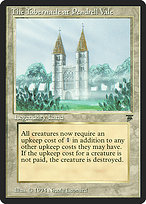


    Actual Price: 2500.0
    Predicted Price: 20.880519387871527


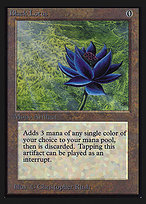


    Actual Price: 2500.0
    Predicted Price: 20.89906292942113


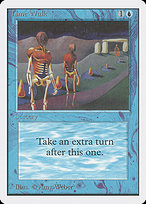


    Actual Price: 2400.0
    Predicted Price: -1.0935773484071183


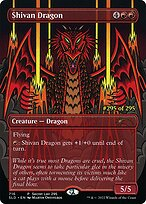

In [ ]:
for i, card in _under_diff_guess_head.iterrows():
    print(f"""
    Actual Price: {card['actual']}
    Predicted Price: {card['predicted']}""")
    display(Image(card['image_uris']['small'].split('?')[0]))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
_rfc = RandomForestRegressor(min_samples_leaf=15,n_jobs=-3)

In [ ]:
ElasticNetCV?

Init signature:
ElasticNetCV(
    *,
    l1_ratio=0.5,
    eps=0.001,
    n_alphas=100,
    alphas=None,
    fit_intercept=True,
    precompute='auto',
    max_iter=1000,
    tol=0.0001,
    cv=None,
    copy_X=True,
    verbose=0,
    n_jobs=None,
    positive=False,
    random_state=None,
    selection='cyclic',
)
Docstring:     
Elastic Net model with iterative fitting along a regularization path.

See glossary entry for :term:`cross-validation estimator`.

Read more in the :ref:`User Guide <elastic_net>`.

Parameters
----------
l1_ratio : float or list of float, default=0.5
    Float between 0 and 1 passed to ElasticNet (scaling between
    l1 and l2 penalties). For ``l1_ratio = 0``
    the penalty is an L2 penalty. For ``l1_ratio = 1`` it is an L1 penalty.
    For ``0 < l1_ratio < 1``, the penalty is a combination of L1 and L2
    This parameter can be a list, in which case the different
    values are tested by cross-validation and the one giving the best
    prediction score is 

In [ ]:
_rfc.fit(train_normal.drop(),train_normal)

/home/jd/anaconda3/envs/spells/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


RandomForestRegressor(min_samples_leaf=15, n_jobs=-3)

In [ ]:
_cvs = -cross_val_score(_rfc,train_normal,train_normal,scoring='neg_root_mean_squared_error')

/home/jd/anaconda3/envs/spells/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/jd/anaconda3/envs/spells/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/jd/anaconda3/envs/spells/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/jd/anaconda3/envs/spells/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/jd/anaconda3/envs/spells/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will

In [ ]:
_cvs, _cvs.mean()

(array([120.41430193,  52.7210387 ,  57.60632632,  90.67132104,
         49.12487748]),
 74.10757309483479)

In [ ]:
from sklearn.ensemble import RandomForestRegressor, \
    ExtraTreesRegressor

## =======================================================

## EXPLORATORY OPTIONS  

## =======================================================

In [ ]:
ERROR OUT HERE :)

SyntaxError: unmatched ')' (135554715.py, line 1)

In [ ]:
_exploded = _sampled_cards.explode('abilities_list')
_ex_vec = cvec.fit_transform(_exploded['abilities_list'])
_ex_test = pd.DataFrame.sparse.from_spmatrix(_ex_vec)

In [ ]:
_ex_test.columns = sorted(cvec.vocabulary_)

In [ ]:
_id_list = _exploded['id'].values

In [ ]:
_ex_test['id'] = _id_list

In [ ]:
_ex_test.groupby('id').agg(sum)

,+1/+0,+1/+0 end,+1/+0 end turn,+1/+1,+1/+1 counter,+1/+1 counter cardname,+1/+1 counter loyalty,+1/+1 counter loyalty counter,+2/+1,+2/+1 end,...,{2} cast next,{2} cast next turn,{b},{b} pay,{b} pay life,{b} pay life put,{t},{t} add,{t} add {w},{w}
id,,,,,,,,,,,,,,,,,,,,,
05414ba7-0f59-4c73-931c-e599d149d3ba,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11ec63a8-6cc7-44f0-9947-c9ff361ca0c8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129bb02e-1fe7-4faa-8ced-624e58475107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14c341ab-fb4d-4967-8ee0-1dcbe5a37824,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26413356-327c-494b-a895-0a0ddd466242,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2d016c5f-265b-4426-8dd8-87872f075f33,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
572e9d19-263b-4c6c-a7f0-143d3d5a4bc5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5a0ed012-1dea-4967-a618-0d7d90a0eab8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
612ecb2c-e732-40cc-9e92-d18b80a26c4c,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
cvec_test = cvec.fit_transform(train['abilities_list'].iloc[_test_card_no])
_test_df = pd.DataFrame.sparse.from_spmatrix(cvec_test)
_test_df.columns = sorted(cvec.vocabulary_)
display(_test_df)#,_test_df.describe())

NameError: name '_test_card_no' is not defined

In [ ]:
cvec_test.

50

In [ ]:
dict(_test_df.astype(int).sum().items())

{'card': 1,
 'creature': 1,
 'creature mutate': 1,
 'creature mutate draw': 1,
 'creature mutate draw card': 1,
 'draw': 1,
 'draw card': 1,
 'fly': 1,
 'mutate': 2,
 'mutate draw': 1,
 'mutate draw card': 1,
 'mutate {3}': 1,
 'mutate {3} {u}': 1,
 'whenever': 1,
 'whenever creature': 1,
 'whenever creature mutate': 1,
 'whenever creature mutate draw': 1,
 '{3}': 1,
 '{3} {u}': 1,
 '{u}': 1}

In [ ]:
cvec_test.data

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
_test_dict

{'card': 1,
 'creature': 1,
 'creature mutate': 1,
 'creature mutate draw': 1,
 'creature mutate draw card': 1,
 'draw': 1,
 'draw card': 1,
 'fly': 1,
 'mutate': 1,
 'mutate draw': 1,
 'mutate draw card': 1,
 'mutate {3}': 1,
 'mutate {3} {u}': 1,
 'whenever': 1,
 'whenever creature': 1,
 'whenever creature mutate': 1,
 'whenever creature mutate draw': 1,
 '{3}': 1,
 '{3} {u}': 1,
 '{u}': 1}

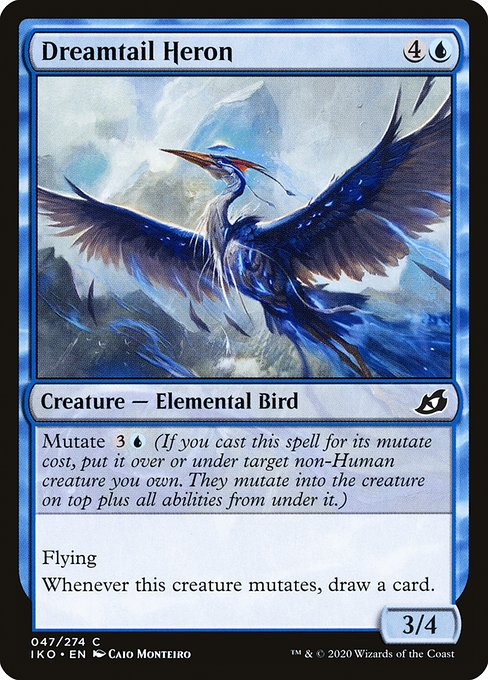

'Mutate {3}{U} (If you cast this spell for its mutate cost, put it over or under target non-Human creature you own. They mutate into the creature on top plus all abilities from under it.)\nFlying\nWhenever this creature mutates, draw a card.'

['mutate {3} {u}  ', ' fly ', ' whenever creature mutate draw card']

In [ ]:
display(Image(train.iloc[_test_card_no]['image_uris']['normal'].split('?')[0]),
    train.iloc[_test_card_no]['oracle_text'],
    train.iloc[_test_card_no]['abilities_list'],
    )